Saving archive (3).zip to archive (3).zip
Dataset Loaded Successfully!

                             Patient_ID  Age     Sex Family_History  \
0  b2a49170-8561-4665-9371-2240b55dd87a   31    Male             No   
1  f5fae45d-8718-41c4-a957-6928f79f3c8e   33  Female            Yes   
2  66ab0567-050b-4d56-9ec4-b676309899a6   69    Male            Yes   
3  996a48e4-e841-418f-a539-5a7a86cd815d   66    Male            Yes   
4  d45c7ca8-7125-4aaa-8018-5bbc60d35a1f   43  Female            Yes   

   HTT_CAG_Repeat_Length Motor_Symptoms Cognitive_Decline  Chorea_Score  \
0                     67       Moderate            Severe          8.80   
1                     38         Severe          Moderate          3.24   
2                     37         Severe          Moderate          1.01   
3                     50           Mild            Severe          3.21   
4                     48       Moderate              Mild          2.31   

   Brain_Volume_Loss  Functional_Capacity  ... HTT

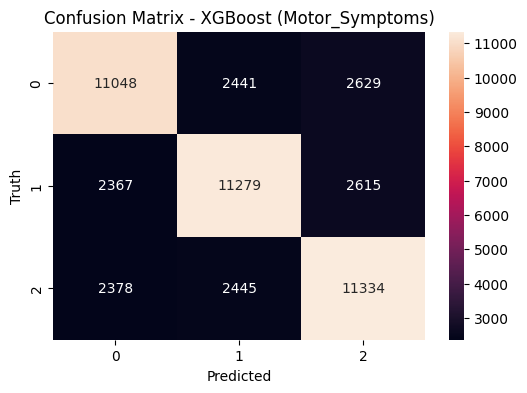


Training XGBoost for: Disease_Stage
Accuracy: 0.6450
Precision: 0.6454
Recall: 0.6450
F1 Score: 0.6450


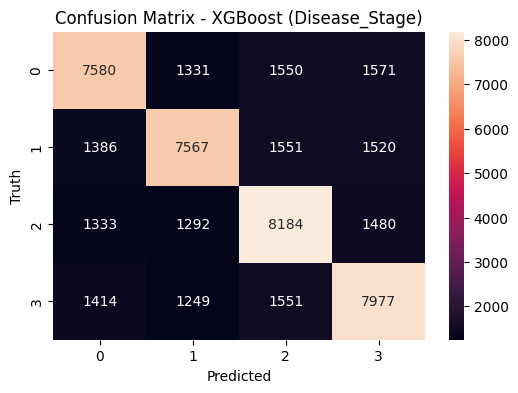


Training XGBoost for: Category
Accuracy: 0.6140
Precision: 0.7487
Recall: 0.6140
F1 Score: 0.5476


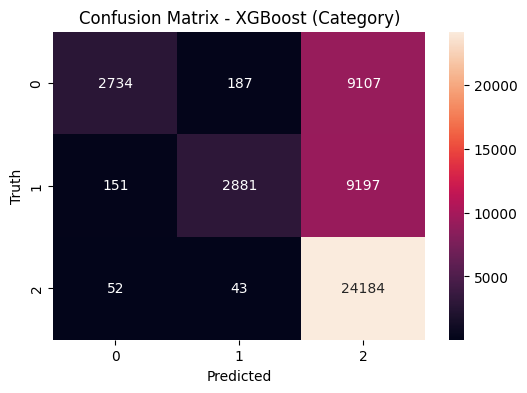


Training AdaBoost for: Motor_Symptoms
Accuracy: 0.3490
Precision: 0.3489
Recall: 0.3490
F1 Score: 0.3450


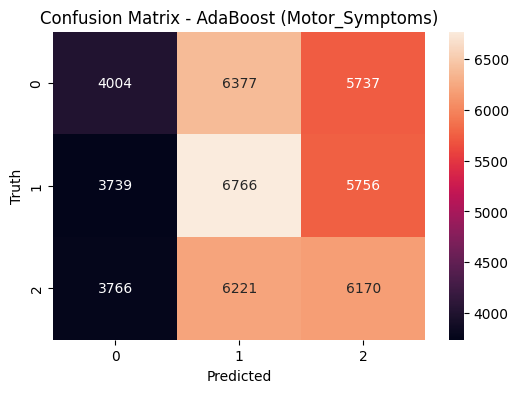


Training AdaBoost for: Disease_Stage
Accuracy: 0.2583
Precision: 0.2569
Recall: 0.2583
F1 Score: 0.2452


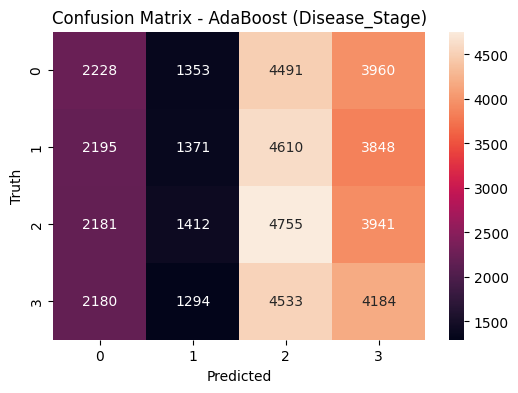


Training AdaBoost for: Category
Accuracy: 0.5002
Precision: 0.2502
Recall: 0.5002
F1 Score: 0.3336


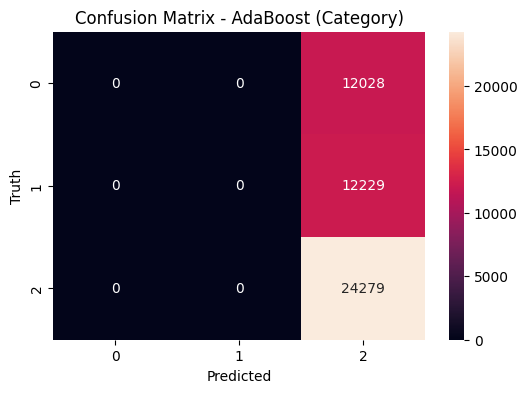


===== Comparison of Final Model Results =====
      Model          Target  Accuracy  Precision    Recall  F1 Score
0   XGBoost  Motor_Symptoms  0.693526   0.693661  0.693526  0.693529
1   XGBoost   Disease_Stage  0.645047   0.645412  0.645047  0.644990
2   XGBoost        Category  0.613957   0.748744  0.613957  0.547568
3  AdaBoost  Motor_Symptoms  0.349019   0.348879  0.349019  0.344979
4  AdaBoost   Disease_Stage  0.258324   0.256856  0.258324  0.245208
5  AdaBoost        Category  0.500227   0.250227  0.500227  0.333585

Per-Target Accuracy:
XGBoost - Motor_Symptoms: 69.35%
XGBoost - Disease_Stage: 64.50%
XGBoost - Category: 61.40%
AdaBoost - Motor_Symptoms: 34.90%
AdaBoost - Disease_Stage: 25.83%
AdaBoost - Category: 50.02%

Overall Dataset Accuracy (Average of all targets):
XGBoost: 65.08%
AdaBoost: 36.92%


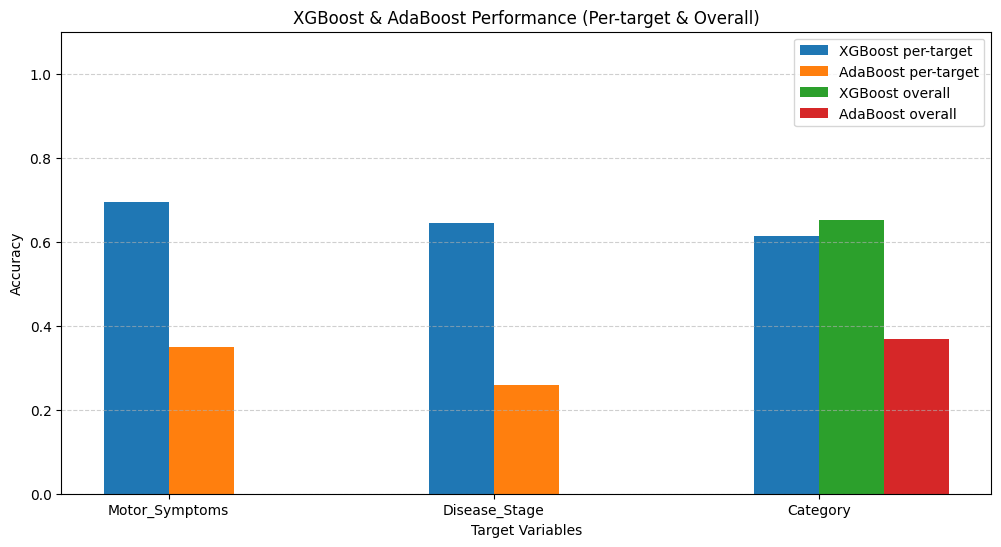

In [1]:
# Import libraries
import pandas as pd
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

!pip install -U xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier


# Upload and load dataset
uploaded = files.upload()
zip_filename = list(uploaded.keys())[0]

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("/content/")

extracted_files = os.listdir("/content/")
csv_file = [f for f in extracted_files if f.endswith(".csv")][0]
csv_path = os.path.join("/content/", csv_file)

df = pd.read_csv(csv_path)
print("Dataset Loaded Successfully!\n")
print(df.head(), "\n")
print("Dataset Info:\n")
print(df.info(), "\n")


# Clean missing values
df = df.ffill()
print("\nMissing values after cleaning:\n")
print(df.isnull().sum())


# Remove high-leakage columns
df = df.drop(columns=[
    "Patient_ID", "Function", "Effect", "Gene/Factor",
    "Chromosome_Location", "Random_Protein_Sequence",
    "Random_Gene_Sequence"
], errors='ignore')


# Label encoding
label_encoders = {}

for col in df.select_dtypes(include="object"):
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print("\nMotor_Symptoms value counts:")
print(df["Motor_Symptoms"].value_counts())
print("\nDisease_Stage value counts:")
print(df["Disease_Stage"].value_counts())
print("\nCategory value counts:")
print(df["Category"].value_counts())


# Feature scaling
X = df.drop(columns=["Motor_Symptoms", "Disease_Stage", "Category"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Function for training and evaluation
results = []

def run_model(target, model_name):
    print("\n========================================")
    print(f"Training {model_name} for: {target}")
    print("========================================")

    y = df[target]

    if model_name == "XGBoost":
        model = XGBClassifier(eval_metric='mlogloss', random_state=42)
    elif model_name == "AdaBoost":
        model = AdaBoostClassifier(n_estimators=200, random_state=42)

    model.fit(X_scaled, y)
    y_pred = model.predict(X_scaled)

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix - {model_name} ({target})")
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.show()

    results.append([model_name, target, acc, prec, rec, f1])


# Run XGBoost and AdaBoost
for model_type in ["XGBoost", "AdaBoost"]:
    run_model("Motor_Symptoms", model_type)
    run_model("Disease_Stage", model_type)
    run_model("Category", model_type)


# Final results summary
results_df = pd.DataFrame(results, columns=["Model", "Target", "Accuracy", "Precision", "Recall", "F1 Score"])
print("\n===== Comparison of Final Model Results =====")
print(results_df)


# Per-target accuracy
print("\nPer-Target Accuracy:")
for index, row in results_df.iterrows():
    print(f"{row['Model']} - {row['Target']}: {row['Accuracy']*100:.2f}%")


# Overall accuracy summary
print("\nOverall Dataset Accuracy (Average of all targets):")
overall_acc_dict = {}
for model in results_df["Model"].unique():
    subset = results_df[results_df["Model"] == model]
    avg_acc = subset["Accuracy"].mean()
    overall_acc_dict[model] = avg_acc
    print(f"{model}: {avg_acc*100:.2f}%")


# Performance bar chart
plt.figure(figsize=(12,6))
bar_width = 0.2
positions = np.arange(len(results_df["Target"].unique()))

for i, model in enumerate(results_df["Model"].unique()):
    subset = results_df[results_df["Model"] == model]
    plt.bar(positions + i*bar_width, subset["Accuracy"], width=bar_width, label=f"{model} per-target")

for i, model in enumerate(results_df["Model"].unique()):
    plt.bar(positions[-1] + (i+1)*bar_width, overall_acc_dict[model], width=bar_width, label=f"{model} overall")

plt.xticks(positions + bar_width/2, results_df["Target"].unique())
plt.title("XGBoost & AdaBoost Performance (Per-target & Overall)")
plt.xlabel("Target Variables")
plt.ylabel("Accuracy")
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [2]:
# Import libraries
import pandas as pd
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

!pip install -U xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier




In [3]:
# Upload and load dataset
uploaded = files.upload()
zip_filename = list(uploaded.keys())[0]

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("/content/")

extracted_files = os.listdir("/content/")
csv_file = [f for f in extracted_files if f.endswith(".csv")][0]
csv_path = os.path.join("/content/", csv_file)

df = pd.read_csv(csv_path)
print("Dataset Loaded Successfully!\n")
print(df.head(), "\n")
print("Dataset Info:\n")
print(df.info(), "\n")

Saving archive (3).zip to archive (3) (1).zip
Dataset Loaded Successfully!

                             Patient_ID  Age     Sex Family_History  \
0  b2a49170-8561-4665-9371-2240b55dd87a   31    Male             No   
1  f5fae45d-8718-41c4-a957-6928f79f3c8e   33  Female            Yes   
2  66ab0567-050b-4d56-9ec4-b676309899a6   69    Male            Yes   
3  996a48e4-e841-418f-a539-5a7a86cd815d   66    Male            Yes   
4  d45c7ca8-7125-4aaa-8018-5bbc60d35a1f   43  Female            Yes   

   HTT_CAG_Repeat_Length Motor_Symptoms Cognitive_Decline  Chorea_Score  \
0                     67       Moderate            Severe          8.80   
1                     38         Severe          Moderate          3.24   
2                     37         Severe          Moderate          1.01   
3                     50           Mild            Severe          3.21   
4                     48       Moderate              Mild          2.31   

   Brain_Volume_Loss  Functional_Capacity  ...

In [4]:
# Clean missing values
df = df.ffill()
print("\nMissing values after cleaning:\n")
print(df.isnull().sum())

# Remove high-leakage columns
df = df.drop(columns=[
    "Patient_ID", "Function", "Effect", "Gene/Factor",
    "Chromosome_Location", "Random_Protein_Sequence",
    "Random_Gene_Sequence"
], errors='ignore')

# Label encoding
label_encoders = {}

for col in df.select_dtypes(include="object"):
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print("\nMotor_Symptoms value counts:")
print(df["Motor_Symptoms"].value_counts())
print("\nDisease_Stage value counts:")
print(df["Disease_Stage"].value_counts())
print("\nCategory value counts:")
print(df["Category"].value_counts())


Missing values after cleaning:

Patient_ID                   0
Age                          0
Sex                          0
Family_History               0
HTT_CAG_Repeat_Length        0
Motor_Symptoms               0
Cognitive_Decline            0
Chorea_Score                 0
Brain_Volume_Loss            0
Functional_Capacity          0
Gene_Mutation_Type           0
HTT_Gene_Expression_Level    0
Protein_Aggregation_Level    0
Random_Protein_Sequence      0
Random_Gene_Sequence         0
Disease_Stage                0
Gene/Factor                  0
Chromosome_Location          0
Function                     0
Effect                       0
Category                     0
dtype: int64

Motor_Symptoms value counts:
Motor_Symptoms
1    16261
2    16157
0    16118
Name: count, dtype: int64

Disease_Stage value counts:
Disease_Stage
2    12289
3    12191
0    12032
1    12024
Name: count, dtype: int64

Category value counts:
Category
2    24279
1    12229
0    12028
Name: count, dtype: 

In [5]:
# Feature scaling
X = df.drop(columns=["Motor_Symptoms", "Disease_Stage", "Category"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Function for training and evaluation
results = []

def run_model(target, model_name):
    print("\n========================================")
    print(f"Training {model_name} for: {target}")
    print("========================================")

    y = df[target]

    if model_name == "XGBoost":
        model = XGBClassifier(eval_metric='mlogloss', random_state=42)
    elif model_name == "AdaBoost":
        model = AdaBoostClassifier(n_estimators=200, random_state=42)

    model.fit(X_scaled, y)
    y_pred = model.predict(X_scaled)

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix - {model_name} ({target})")
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.show()

    results.append([model_name, target, acc, prec, rec, f1])



Training XGBoost for: Motor_Symptoms
Accuracy: 0.6935
Precision: 0.6937
Recall: 0.6935
F1 Score: 0.6935


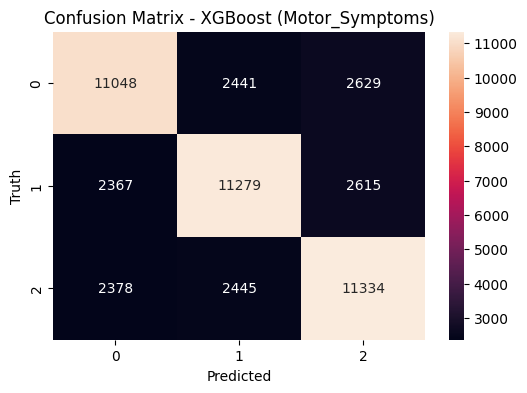


Training XGBoost for: Disease_Stage
Accuracy: 0.6450
Precision: 0.6454
Recall: 0.6450
F1 Score: 0.6450


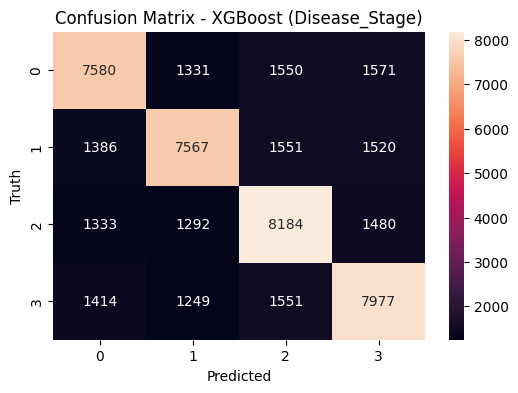


Training XGBoost for: Category
Accuracy: 0.6140
Precision: 0.7487
Recall: 0.6140
F1 Score: 0.5476


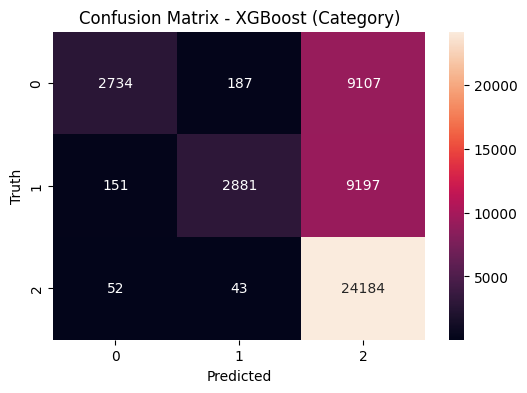


Training AdaBoost for: Motor_Symptoms
Accuracy: 0.3490
Precision: 0.3489
Recall: 0.3490
F1 Score: 0.3450


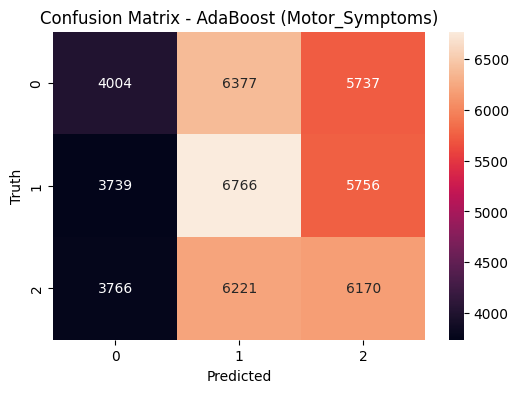


Training AdaBoost for: Disease_Stage
Accuracy: 0.2583
Precision: 0.2569
Recall: 0.2583
F1 Score: 0.2452


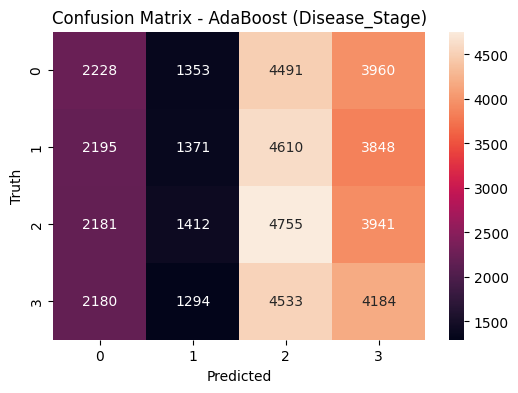


Training AdaBoost for: Category
Accuracy: 0.5002
Precision: 0.2502
Recall: 0.5002
F1 Score: 0.3336


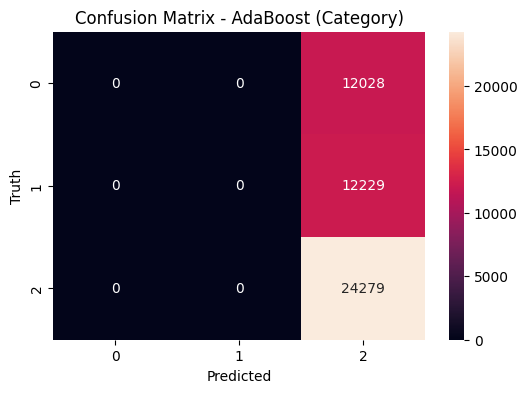

In [6]:
# Run XGBoost and AdaBoost
for model_type in ["XGBoost", "AdaBoost"]:
    run_model("Motor_Symptoms", model_type)
    run_model("Disease_Stage", model_type)
    run_model("Category", model_type)


In [7]:
# Final results summary
results_df = pd.DataFrame(results, columns=["Model", "Target", "Accuracy", "Precision", "Recall", "F1 Score"])
print("\n===== Comparison of Final Model Results =====")
print(results_df)


# Per-target accuracy
print("\nPer-Target Accuracy:")
for index, row in results_df.iterrows():
    print(f"{row['Model']} - {row['Target']}: {row['Accuracy']*100:.2f}%")


# Overall accuracy summary
print("\nOverall Dataset Accuracy (Average of all targets):")
overall_acc_dict = {}
for model in results_df["Model"].unique():
    subset = results_df[results_df["Model"] == model]
    avg_acc = subset["Accuracy"].mean()
    overall_acc_dict[model] = avg_acc
    print(f"{model}: {avg_acc*100:.2f}%")




===== Comparison of Final Model Results =====
      Model          Target  Accuracy  Precision    Recall  F1 Score
0   XGBoost  Motor_Symptoms  0.693526   0.693661  0.693526  0.693529
1   XGBoost   Disease_Stage  0.645047   0.645412  0.645047  0.644990
2   XGBoost        Category  0.613957   0.748744  0.613957  0.547568
3  AdaBoost  Motor_Symptoms  0.349019   0.348879  0.349019  0.344979
4  AdaBoost   Disease_Stage  0.258324   0.256856  0.258324  0.245208
5  AdaBoost        Category  0.500227   0.250227  0.500227  0.333585

Per-Target Accuracy:
XGBoost - Motor_Symptoms: 69.35%
XGBoost - Disease_Stage: 64.50%
XGBoost - Category: 61.40%
AdaBoost - Motor_Symptoms: 34.90%
AdaBoost - Disease_Stage: 25.83%
AdaBoost - Category: 50.02%

Overall Dataset Accuracy (Average of all targets):
XGBoost: 65.08%
AdaBoost: 36.92%


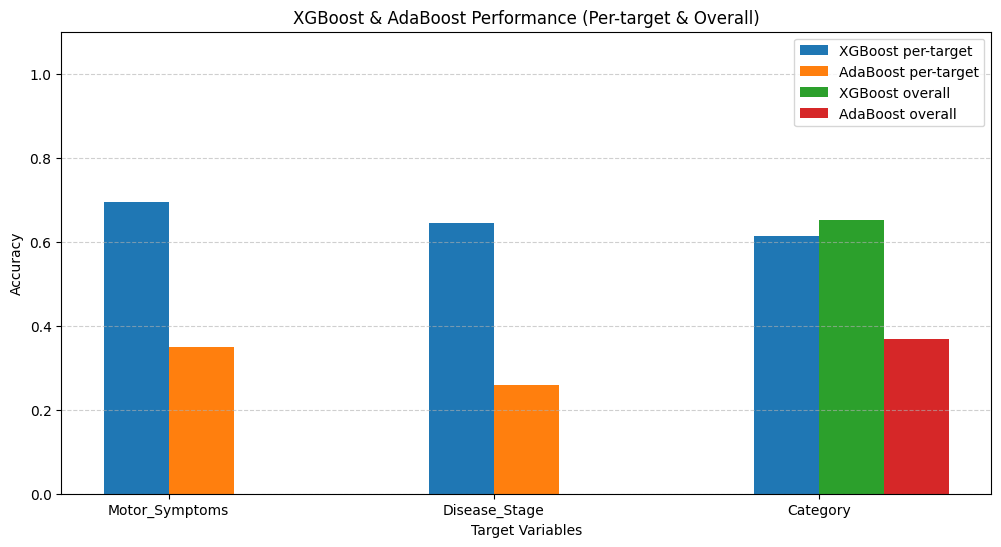

In [8]:
# Performance bar chart
plt.figure(figsize=(12,6))
bar_width = 0.2
positions = np.arange(len(results_df["Target"].unique()))

for i, model in enumerate(results_df["Model"].unique()):
    subset = results_df[results_df["Model"] == model]
    plt.bar(positions + i*bar_width, subset["Accuracy"], width=bar_width, label=f"{model} per-target")

for i, model in enumerate(results_df["Model"].unique()):
    plt.bar(positions[-1] + (i+1)*bar_width, overall_acc_dict[model], width=bar_width, label=f"{model} overall")

plt.xticks(positions + bar_width/2, results_df["Target"].unique())
plt.title("XGBoost & AdaBoost Performance (Per-target & Overall)")
plt.xlabel("Target Variables")
plt.ylabel("Accuracy")
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()